<a href="https://cognitiveclass.ai"><img src = "https://ibm.box.com/shared/static/9gegpsmnsoo25ikkbl4qzlvlyjbgxs5x.png" width = 400> </a>

<h1 align=center><font size = 5>CAPSTONE PROJECT: ZURICH</font></h1>
<h2 align=center><font size = 5>Author: HongX</font></h2><h2 align=center><font size = 4>Student at ETH Zürich (2019)</font></h2>

# Introduction

In this notebook, I presented how to apply the knowledge learned from coursera data science courses to the tasks of segmenting and clustering neighborhoods in Toronto, Canada.  

List of used tools:  
**1.Python 3**  
**2.Foursqure**  
**3.Skills Network Labs Platform**  

*Adapted notebook from course: DP0701EN-3-3-2-Neighborhoods-New-York-py-v1.0.ipynb

## Table of Week Tasks

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Week 1: Set up Coursera Capstone Notebook on Github</a>

2. <a href="#item2">Week 2: Foursquare API</a>

3. <a href="#item3">Week 3: Segmenting and Clustering Neighborhoods in Toronto</a>

4. <a href="#item4">Week 4: The Battle of Neighborhoods</a>

5. <a href="#item5">Week 5: The Battle of Neighborhoods (Cont'd) and Summary Report</a>    
</font>
</div>

# Week 1: Set up Coursera Capstone Notebook on Github

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [4]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print ('Hello Capstone Project Course!')

Hello Capstone Project Course!


In [5]:
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!pip install beautifulsoup4
from bs4 import BeautifulSoup # scraping library

print('All Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

All Libraries imported.


In [6]:
from scipy.spatial.distance import cdist

# Week 2: Foursquare API

Set up Foursquare API request and get the free developer account:

**ID & SECRET**  
CLIENT ID: B3BH45CIBXDSORQEH34IK0XKNZ3M5WO01D42JFZGIUUM24N4  
CLIENT SECRET: SAIWO2LIYUIZRN1J2P5OYVFMUJR3UAOAJWA0RCTXPOBCSP2B

Your current account tier is Sandbox:  
**950 Regular Calls/Day**  
**50 Premium Calls/Day**  
1 Photo per Venue  
1 Tip per Venue  

Endpoint Checking List: https://developer.foursquare.com/docs/api/endpoints

# Week 3: Segmenting and Clustering Neighborhoods in Zurich

## 1. Transform the Zurich neighberhood table into pandas dataframe

In [24]:
#create a Neighborhoods dataframe
local_path = os.getcwd()
print (local_path)

url_zrh_post = '/resources/labs/DP0701EN/Update_Zurich_Postcode.csv'

neighbor_df = pd.read_csv(url_zrh_post)
neighbor_df.head(10)

/resources/labs/DP0701EN


,Postcode,Borough,Neighbourhood
0,8000,Zurich,HauptBahnhof
1,8001,Zurich,Altstadt
2,8001,Zurich,Hochschulen
3,8001,Zurich,Hottingen
4,8001,Zurich,Lindenhof
5,8001,Zurich,Rathaus
6,8002,Zurich,Enge
7,8003,Zurich,Alt-Wiedikon
8,8003,Zurich,Sihlfeld
9,8004,Zurich,Hard


In [25]:
print (neighbor_df.shape)

(299, 3)


## 2. Clean and Preparation of Dataframe

To create the above dataframe:  

* The dataframe will consist of three columns: **PostalCode, Borough, and Neighborhood**   
* Only process the cells that have an assigned borough. **Ignore cells with a borough that is Not assigned**.    
* More than one neighborhood can exist in one postal code area.   
* If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.  
* Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.  
* In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.  
* Submit a link to your Notebook on your Github repository. (10 marks)  

In [26]:
#Remove cells with a borough that is Not assigned.
neighbor_df.drop(neighbor_df.index[neighbor_df.index[neighbor_df['Borough'] == 'NaN']], inplace=True)

neighbor_df.head(10)

,Postcode,Borough,Neighbourhood
0,8000,Zurich,HauptBahnhof
1,8001,Zurich,Altstadt
2,8001,Zurich,Hochschulen
3,8001,Zurich,Hottingen
4,8001,Zurich,Lindenhof
5,8001,Zurich,Rathaus
6,8002,Zurich,Enge
7,8003,Zurich,Alt-Wiedikon
8,8003,Zurich,Sihlfeld
9,8004,Zurich,Hard


In [27]:
neighbor_df.shape

(299, 3)

## 3. Add the Latitute and Longitude value from Geolocator

In [28]:
def address_loc(address):
    
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    if location is not None:
        latitude = location.latitude
        longitude = location.longitude
    else:
        latitude = 0
        longitude = 0
    #print('The geograpical coordinate of '+address+' are {}, {}.'.format(latitude, longitude))    
    return float(latitude), float(longitude)

neighbor_df['Latitude'] = float(0)
neighbor_df['Longitude'] = float(0)

for i in range(0, neighbor_df.shape[0]):

    #address_str = str(neighbor_df['Neighbourhood'][i])+', '+str(neighbor_df['Postcode'][i])+' '+str(neighbor_df['Borough'][i])+', Switzerland'
    address_str = str(neighbor_df['Neighbourhood'][i])+' '+str(neighbor_df['Postcode'][i])+', Switzerland'
    lati, logi = address_loc(address=address_str)
    neighbor_df.at[i, 'Latitude']=lati
    neighbor_df.at[i, 'Longitude']=logi   

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,8000,Zurich,HauptBahnhof,47.500300,8.724242
1,8001,Zurich,Altstadt,47.372233,8.542329
2,8001,Zurich,Hochschulen,47.373846,8.548613
3,8001,Zurich,Hottingen,47.369680,8.555082
4,8001,Zurich,Lindenhof,47.372916,8.540176
5,8001,Zurich,Rathaus,47.372649,8.544311
6,8002,Zurich,Enge,47.361789,8.528708
7,8003,Zurich,Alt-Wiedikon,47.365562,8.517851
8,8003,Zurich,Sihlfeld,47.373218,8.510820
9,8004,Zurich,Hard,47.381743,8.512554


In [29]:
neighbor_df.shape
neighbor_df.head(10)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,8000,Zurich,HauptBahnhof,47.500300,8.724242
1,8001,Zurich,Altstadt,47.372233,8.542329
2,8001,Zurich,Hochschulen,47.373846,8.548613
3,8001,Zurich,Hottingen,47.369680,8.555082
4,8001,Zurich,Lindenhof,47.372916,8.540176
5,8001,Zurich,Rathaus,47.372649,8.544311
6,8002,Zurich,Enge,47.361789,8.528708
7,8003,Zurich,Alt-Wiedikon,47.365562,8.517851
8,8003,Zurich,Sihlfeld,47.373218,8.510820
9,8004,Zurich,Hard,47.381743,8.512554


In [41]:
neighbor_df.at[0, 'Latitude'] = 47.3761163
neighbor_df.at[0, 'Longitude'] = 8.5398584

In [43]:
neighbor_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,8000,Zurich,HauptBahnhof,47.376116,8.539858
1,8001,Zurich,Altstadt,47.372233,8.542329
2,8001,Zurich,Hochschulen,47.373846,8.548613
3,8001,Zurich,Hottingen,47.369680,8.555082
4,8001,Zurich,Lindenhof,47.372916,8.540176


## 4. Create a map of Zurich with neighborhoods superimposed on top.

In [39]:
address = 'Zurich Main Station 8000, Switzerland'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of '+address+' are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Zurich Main Station 8000, Switzerland are 47.4396787, 8.4717407.


In [44]:
# create map of Toronto using latitude and longitude values
map_zurich = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbor in zip(neighbor_df['Latitude'], neighbor_df['Longitude'], neighbor_df['Borough'], neighbor_df['Neighbourhood']):
    label = '{}, {}'.format(neighbor, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_zurich)  
    
map_zurich

## 5. Select Zurich City Area for Analysis

In [45]:
neighbor_df.head()
neighbor_df.shape
swiss_df = neighbor_df.copy()
swiss_df.head()
zurich_df = swiss_df.copy()
zurich_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,8000,Zurich,HauptBahnhof,47.376116,8.539858
1,8001,Zurich,Altstadt,47.372233,8.542329
2,8001,Zurich,Hochschulen,47.373846,8.548613
3,8001,Zurich,Hottingen,47.369680,8.555082
4,8001,Zurich,Lindenhof,47.372916,8.540176


In [46]:
for i in range(int(zurich_df.shape[0])):
    if 'Zurich' in zurich_df['Borough'][i]:
        pass
    else:
        zurich_df.drop(i, inplace=True)
        
zurich_df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,8000,Zurich,HauptBahnhof,47.376116,8.539858
1,8001,Zurich,Altstadt,47.372233,8.542329
2,8001,Zurich,Hochschulen,47.373846,8.548613
3,8001,Zurich,Hottingen,47.369680,8.555082
4,8001,Zurich,Lindenhof,47.372916,8.540176


In [47]:
zurich_cdf = zurich_df.copy()
zurich_cdf.drop(zurich_cdf.index[zurich_cdf['Latitude'] == float(0)], inplace=True)
zurich_cdf.head(10)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,8000,Zurich,HauptBahnhof,47.376116,8.539858
1,8001,Zurich,Altstadt,47.372233,8.542329
2,8001,Zurich,Hochschulen,47.373846,8.548613
3,8001,Zurich,Hottingen,47.369680,8.555082
4,8001,Zurich,Lindenhof,47.372916,8.540176
5,8001,Zurich,Rathaus,47.372649,8.544311
6,8002,Zurich,Enge,47.361789,8.528708
7,8003,Zurich,Alt-Wiedikon,47.365562,8.517851
8,8003,Zurich,Sihlfeld,47.373218,8.510820
9,8004,Zurich,Hard,47.381743,8.512554


In [48]:
zurich_cdf.shape

(47, 5)

In [49]:
# create map of Toronto using latitude and longitude values
map_zurich_city = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbor in zip(zurich_cdf['Latitude'], zurich_cdf['Longitude'], zurich_cdf['Borough'], zurich_cdf['Neighbourhood']):
    label = '{}, {}'.format(neighbor, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_zurich_city)  
    
map_zurich_city

## 6. Simplifiy the Plot using Matplotlib

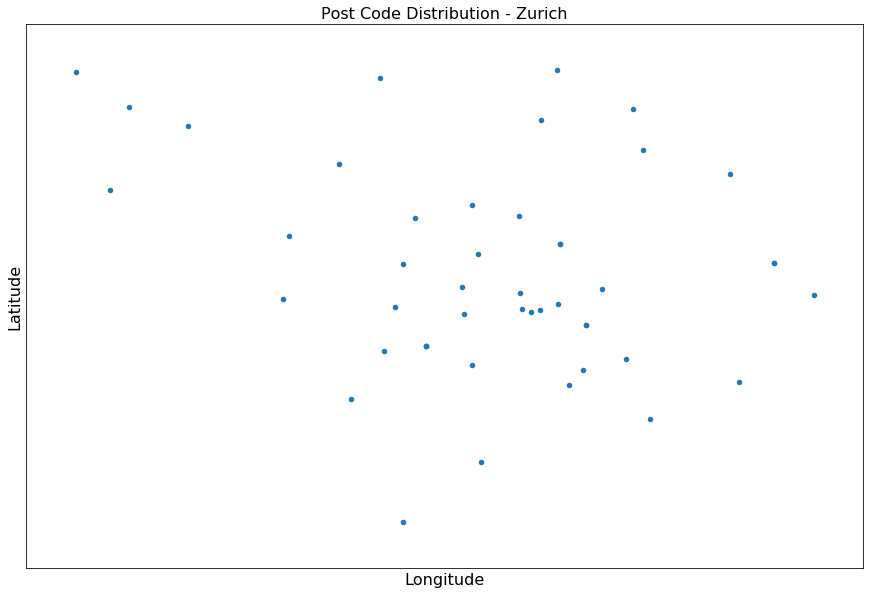

In [51]:
import matplotlib.pyplot as plt

X = zurich_cdf[['Longitude', 'Latitude']]

scatter_plot = X.plot.scatter(x='Longitude', 
               y='Latitude',  
               fontsize = 16,
               figsize=(15, 10))

scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
scatter_plot.set_title('Post Code Distribution - Zurich', fontsize=16)
scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

## 7. Clustering the place using kMeans

In [52]:
# coding:utf-8

import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

X = zurich_cdf[['Longitude', 'Latitude']]

#Define a kMean function:
def kMeans_func(X, clusters=2):
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(X)
    return kmeans.labels_

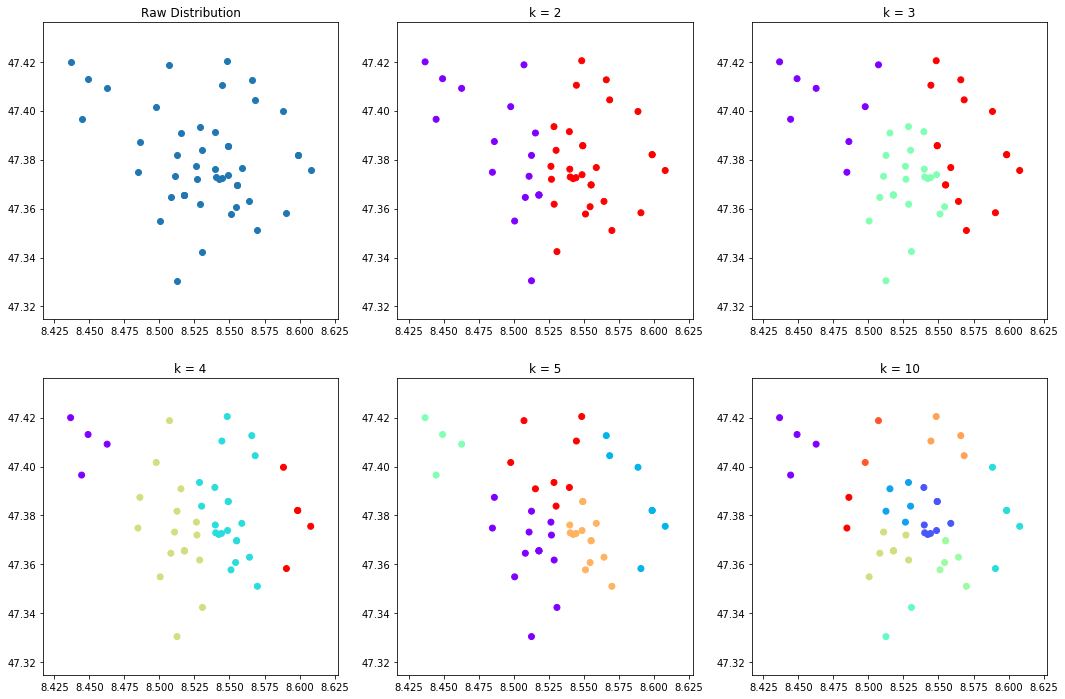

In [53]:
#Plot the kMean Results with different k value:
plt.figure(figsize=(18,12))
#plt.axis([0, 5, 0, 5])
plt.grid(True)

ax1 = plt.subplot(2, 3, 1)
plt.scatter(zurich_cdf['Longitude'],zurich_cdf['Latitude'])
ax1.set_title("Raw Distribution")

ax2 = plt.subplot(2, 3, 2)
plt.scatter(zurich_cdf['Longitude'],zurich_cdf['Latitude'], c=kMeans_func(X, clusters=2), cmap='rainbow')
ax2.set_title("k = 2")

ax3 = plt.subplot(2, 3, 3)
plt.scatter(zurich_cdf['Longitude'],zurich_cdf['Latitude'], c=kMeans_func(X, clusters=3), cmap='rainbow')
ax3.set_title("k = 3")

ax4 = plt.subplot(2, 3, 4)
plt.scatter(zurich_cdf['Longitude'],zurich_cdf['Latitude'], c=kMeans_func(X, clusters=4), cmap='rainbow')
ax4.set_title("k = 4")

ax5 = plt.subplot(2, 3, 5)
plt.scatter(zurich_cdf['Longitude'],zurich_cdf['Latitude'], c=kMeans_func(X, clusters=5), cmap='rainbow')
ax5.set_title("k = 5")

ax6 = plt.subplot(2, 3, 6)
plt.scatter(zurich_cdf['Longitude'],zurich_cdf['Latitude'], c=kMeans_func(X, clusters=10), cmap='rainbow')
ax6.set_title("k = 10")

plt.show()

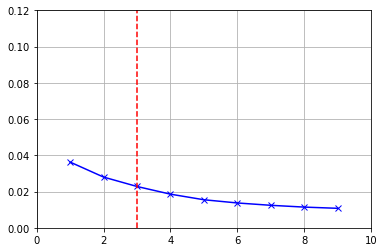

According to the k =3 is the best as k value for kMeans clustering!


In [54]:
K = range(1, 10)
meandistortions = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    # 求kmeans的成本函数值
    meandistortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

plt.figure()
plt.axis([0, 10, 0, 0.12])
plt.grid(True)
plt.plot(K, meandistortions, 'bx-')
plt.axvline(x=3, color='r', linestyle='--')
plt.show()

print ('According to the k =3 is the best as k value for kMeans clustering!')

## 8.Define Foursquare Credentials and Version


In [55]:
CLIENT_ID = 'B3BH45CIBXDSORQEH34IK0XKNZ3M5WO01D42JFZGIUUM24N4' # your Foursquare ID
CLIENT_SECRET = 'SAIWO2LIYUIZRN1J2P5OYVFMUJR3UAOAJWA0RCTXPOBCSP2B' # your Foursquare Secret
VERSION = '20190805' # Foursquare API version
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: B3BH45CIBXDSORQEH34IK0XKNZ3M5WO01D42JFZGIUUM24N4
CLIENT_SECRET:SAIWO2LIYUIZRN1J2P5OYVFMUJR3UAOAJWA0RCTXPOBCSP2B


## 9. Exploring Main Station's Neighbourhoods Companies

In [101]:
address = 'Bahnhofplatz, 8001 Zürich, Switzerland'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

search_query = 'AG'
radius = 10000
print(search_query + ' .... OK!')

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

results = requests.get(url).json()

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)

filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
print (dataframe_filtered.shape)
dataframe_filtered.head(50)


47.3769173 8.5414818
AG .... OK!
(30, 16)


,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,HQ Corporate Business Data Quest AG,Office,Bahnhofplatz 1,47.376805,8.541513,"[{'label': 'display', 'lat': 47.376805, 'lng':...",12,8001,CH,Zürich,Zürich,Schweiz,"[Bahnhofplatz 1, 8001 Zürich, Schweiz]",NaN,NaN,4e79c29b52b1fc6a4b083c6d
1,SwissCaution AG,Bank,Bahnhofstrasse 106,47.376325,8.540046,"[{'label': 'display', 'lat': 47.37632524845613...",126,8004,CH,Zürich,Zürich,Schweiz,"[Bahnhofstrasse 106, 8004 Zürich, Schweiz]",NaN,NaN,4fac42f910816467c8707e4b
2,Adtrexa AG,Financial or Legal Service,Gessnerallee,47.376267,8.537023,"[{'label': 'display', 'lat': 47.376267, 'lng':...",343,8001,CH,Zürich,Zürich,Schweiz,"[Gessnerallee, 8001 Zürich, Schweiz]",NaN,NaN,57e8d76f498ed5e3a034d31a
3,Paul Ullrich AG,Wine Shop,Talacker 30,47.371036,8.536528,"[{'label': 'display', 'lat': 47.37103619553228...",753,8001,CH,Zürich,Zürich,Schweiz,"[Talacker 30 (Pelikanplatz), 8001 Zürich, Schw...",Pelikanplatz,City,50d47660e4b07653d22143ba
4,SINCONA Swiss International Coin Auction AG,Home Service,Limmatquai 112,47.375267,8.543548,"[{'label': 'display', 'lat': 47.3752666, 'lng'...",240,8001,CH,Zürich,Zürich,Schweiz,"[Limmatquai 112, 8001 Zürich, Schweiz]",NaN,NaN,575b0ea9498e140b4679e88e
5,Kuoni Mueller & Partner Investment AG,Real Estate Office,Schweizergasse 21,47.376311,8.536956,"[{'label': 'display', 'lat': 47.37631107, 'lng...",347,8001,CH,Zürich,Zürich,Schweiz,"[Schweizergasse 21, 8001 Zürich, Schweiz]",NaN,NaN,4ff54c18e4b0cdc6b7712156
6,Beyer Chronometrie AG,Jewelry Store,Bahnhofstrasse 31,47.370825,8.538815,"[{'label': 'display', 'lat': 47.37082452430891...",707,8001,CH,Zürich,Zürich,Schweiz,"[Bahnhofstrasse 31, 8001 Zürich, Schweiz]",NaN,NaN,50599ea3e4b01470503c8f7f
7,bsb asset management ag,Corporate Amenity,NaN,47.364353,8.533612,"[{'label': 'display', 'lat': 47.36435323429195...",1519,NaN,CH,NaN,NaN,Schweiz,[Schweiz],NaN,NaN,5211c0c8498e45cc226c7077
8,Jumbo-Markt AG,Miscellaneous Shop,Bahnhofstrasse 2,47.371147,8.537822,"[{'label': 'display', 'lat': 47.3711475, 'lng'...",699,8001,CH,Zürich,Zürich,Schweiz,"[Bahnhofstrasse 2, 8001 Zürich, Schweiz]",NaN,NaN,57c6f911498e8cb2adc36553
9,Stählin Elektro AG,Miscellaneous Shop,Bolleystrasse 3,47.381911,8.548546,"[{'label': 'display', 'lat': 47.381911, 'lng':...",769,8006,CH,Zürich,Zürich,Schweiz,"[Bolleystrasse 3, 8006 Zürich, Schweiz]",NaN,NaN,5c067b1f8c35dc002cd346b9


## 10. Explore The Companies in Zurich City according to Postcode

In [102]:
def getNearbyCompanies(names, latitudes, longitudes, search_query, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            search_query, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [104]:
zurich_AG = getNearbyCompanies(names=zurich_cdf['Neighbourhood'],
                                   latitudes=zurich_cdf['Latitude'],
                                   longitudes=zurich_cdf['Longitude'],
                                      search_query='AG'
                                  )

In [113]:
zurich_AG.head(10)
zurich_AG.shape

(118, 7)

In [107]:
zurich_GmbH = getNearbyCompanies(names=zurich_cdf['Neighbourhood'],
                                   latitudes=zurich_cdf['Latitude'],
                                   longitudes=zurich_cdf['Longitude'],
                                      search_query='GmbH'
                                  )

In [112]:
zurich_GmbH.head(10)
zurich_GmbH.shape

(171, 7)

In [109]:
zurich_AG_df = zurich_AG.copy()
zurich_GmbH_df = zurich_GmbH.copy()
companies_df = [zurich_AG_df, zurich_GmbH_df]
zurich_companies = pd.concat(companies_df, ignore_index=True, copy=True)

In [111]:
zurich_companies.head()
zurich_companies.shape

(289, 7)

In [114]:
zurich_companies.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Affoltern,2,2,2,2,2,2
Albisrieden,4,4,4,4,4,4
Alt-Wiedikon,21,21,21,21,21,21
Altstadt,17,17,17,17,17,17
Altstetten,9,9,9,9,9,9
Enge,8,8,8,8,8,8
Escher-Wyss,4,4,4,4,4,4
Fluntern,5,5,5,5,5,5
Friesenberg,3,3,3,3,3,3


In [115]:
print('There are {} uniques categories.'.format(len(zurich_companies['Venue Category'].unique())))

There are 55 uniques categories.


In [140]:
zurich_companies.head(10)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,HauptBahnhof,47.376116,8.539858,St. Josef Hotel,47.375512,8.545615,Hotel
1,HauptBahnhof,47.376116,8.539858,Neumarkt 17 AG,47.372868,8.546121,Furniture / Home Store
2,HauptBahnhof,47.376116,8.539858,Paul Ullrich AG,47.371036,8.536528,Wine Shop
3,HauptBahnhof,47.376116,8.539858,Erne's Euromotos AG,47.382359,8.537571,Motorcycle Shop
4,HauptBahnhof,47.376116,8.539858,SINCONA Swiss International Coin Auction AG,47.375267,8.543548,Home Service
5,HauptBahnhof,47.376116,8.539858,Jumbo-Markt AG,47.371147,8.537822,Miscellaneous Shop
6,HauptBahnhof,47.376116,8.539858,Beyer Chronometrie AG,47.370825,8.538815,Jewelry Store
7,HauptBahnhof,47.376116,8.539858,Sanitas Troesch AG,47.372836,8.530508,Hardware Store
8,HauptBahnhof,47.376116,8.539858,Benz + Cie. AG,47.382258,8.547944,Miscellaneous Shop
9,Altstadt,47.372233,8.542329,St. Josef Hotel,47.375512,8.545615,Hotel


In [120]:
company_map = folium.Map(location=[latitude, longitude], zoom_start=11) # generate map centred around the Conrad Hotel

# add markers to map
for lat, lng, label in zip(zurich_companies['Venue Latitude'], zurich_companies['Venue Longitude'], zurich_companies['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(company_map)  

# display map
company_map

In [121]:
# one hot encoding
zurich_onehot = pd.get_dummies(zurich_companies[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
zurich_onehot['Neighbourhood'] = zurich_companies['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [zurich_onehot.columns[-1]] + list(zurich_onehot.columns[:-1])
zurich_onehot = zurich_onehot[fixed_columns]

zurich_onehot.head()

,Neighbourhood,ATM,Advertising Agency,Arts & Crafts Store,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,Bakery,Bookstore,Bowling Alley,Building,Business Service,Cheese Shop,Clothing Store,Construction & Landscaping,Cosmetics Shop,Dance Studio,Doctor's Office,Electronics Store,Event Service,Flower Shop,Frame Store,Furniture / Home Store,Garden,Garden Center,General Entertainment,Gift Shop,Grocery Store,Hardware Store,Health & Beauty Service,Hobby Shop,Home Service,Hotel,IT Services,Insurance Office,Jewelry Store,Lawyer,Locksmith,Martial Arts Dojo,Massage Studio,Men's Store,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Office,Optical Shop,Other Repair Shop,Photography Studio,Print Shop,Restaurant,Sporting Goods Shop,Student Center,Toy / Game Store,Tram Station,Wine Shop
0,HauptBahnhof,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HauptBahnhof,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HauptBahnhof,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,HauptBahnhof,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,HauptBahnhof,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [122]:
zurich_grouped = zurich_onehot.groupby('Neighbourhood').mean().reset_index()
zurich_grouped.head()

,Neighbourhood,ATM,Advertising Agency,Arts & Crafts Store,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,Bakery,Bookstore,Bowling Alley,Building,Business Service,Cheese Shop,Clothing Store,Construction & Landscaping,Cosmetics Shop,Dance Studio,Doctor's Office,Electronics Store,Event Service,Flower Shop,Frame Store,Furniture / Home Store,Garden,Garden Center,General Entertainment,Gift Shop,Grocery Store,Hardware Store,Health & Beauty Service,Hobby Shop,Home Service,Hotel,IT Services,Insurance Office,Jewelry Store,Lawyer,Locksmith,Martial Arts Dojo,Massage Studio,Men's Store,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Office,Optical Shop,Other Repair Shop,Photography Studio,Print Shop,Restaurant,Sporting Goods Shop,Student Center,Toy / Game Store,Tram Station,Wine Shop
0,Affoltern,0.0,0.0,0.0,0.0,0.000000,0.5,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.500000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
1,Albisrieden,0.0,0.0,0.0,0.0,0.000000,0.0,0.25,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.250000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.250000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000
2,Alt-Wiedikon,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142857,0.000000,0.0,0.000000,0.0,0.142857,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.142857,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.142857,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.142857,0.0,0.0,0.0,0.142857,0.0,0.000000
3,Altstadt,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.058824,0.000000,0.0,0.176471,0.0,0.000000,0.0,0.058824,0.0,0.0,0.000000,0.000000,0.000000,0.058824,0.117647,0.0,0.058824,0.058824,0.058824,0.0,0.058824,0.000000,0.0,0.000000,0.0,0.058824,0.058824,0.0,0.058824,0.058824,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.058824
4,Altstetten,0.0,0.0,0.0,0.0,0.111111,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.000000,0.222222,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.111111,0.111111,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.111111,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.111111,0.000000,0.0,0.111111,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000


In [123]:
num_top_venues = 5

for hood in zurich_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = zurich_grouped[zurich_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Affoltern----
                venue  freq
0  Miscellaneous Shop   0.5
1         Auto Garage   0.5
2                 ATM   0.0
3          Hobby Shop   0.0
4        Home Service   0.0


----Albisrieden----
                        venue  freq
0  Construction & Landscaping  0.25
1             Automotive Shop  0.25
2                      Lawyer  0.25
3              Hardware Store  0.25
4              Student Center  0.00


----Alt-Wiedikon----
              venue  freq
0     Grocery Store  0.14
1  Toy / Game Store  0.14
2            Bakery  0.14
3        Print Shop  0.14
4       Flower Shop  0.14


----Altstadt----
                     venue  freq
0        Electronics Store  0.18
1  Health & Beauty Service  0.12
2          Motorcycle Shop  0.06
3           Hardware Store  0.06
4             Home Service  0.06


----Altstetten----
                        venue  freq
0                Dance Studio  0.22
1  Construction & Landscaping  0.11
2             Auto Dealership  0.11
3              

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = zurich_grouped['Neighbourhood']

for ind in np.arange(zurich_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(zurich_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

In [124]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = zurich_grouped['Neighbourhood']

for ind in np.arange(zurich_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(zurich_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Affoltern,Auto Garage,Miscellaneous Shop,Wine Shop,Clothing Store,Garden Center,Garden,Furniture / Home Store,Frame Store,Flower Shop,Event Service
1,Albisrieden,Construction & Landscaping,Hardware Store,Automotive Shop,Lawyer,Wine Shop,Garden,Furniture / Home Store,Frame Store,Flower Shop,Event Service
2,Alt-Wiedikon,Grocery Store,Martial Arts Dojo,Toy / Game Store,Print Shop,Flower Shop,Bakery,Cosmetics Shop,Garden,Furniture / Home Store,Frame Store
3,Altstadt,Electronics Store,Health & Beauty Service,Wine Shop,Miscellaneous Shop,Hardware Store,Cosmetics Shop,Home Service,Hotel,IT Services,Jewelry Store
4,Altstetten,Dance Studio,General Entertainment,Construction & Landscaping,Gift Shop,Auto Dealership,Other Repair Shop,Motorcycle Shop,Lawyer,Garden,Furniture / Home Store


In [125]:
# set number of clusters
kclusters = 5

zurich_grouped_clustering = zurich_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(zurich_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 4, 0, 0, 4], dtype=int32)

In [141]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

zurich_merged_c = zurich_cdf

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
zurich_merged_c = zurich_merged.merge(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

zurich_merged_c.head(10) # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,1st Most Common Venue_x,2nd Most Common Venue_x,3rd Most Common Venue_x,4th Most Common Venue_x,5th Most Common Venue_x,6th Most Common Venue_x,7th Most Common Venue_x,8th Most Common Venue_x,9th Most Common Venue_x,10th Most Common Venue_x,Cluster Labels,1st Most Common Venue_y,2nd Most Common Venue_y,3rd Most Common Venue_y,4th Most Common Venue_y,5th Most Common Venue_y,6th Most Common Venue_y,7th Most Common Venue_y,8th Most Common Venue_y,9th Most Common Venue_y,10th Most Common Venue_y
0,8000,Zurich,HauptBahnhof,47.376116,8.539858,Motorcycle Shop,Health & Beauty Service,Electronics Store,Miscellaneous Shop,Wine Shop,Hardware Store,Home Service,Hotel,Jewelry Store,Cosmetics Shop,0,Motorcycle Shop,Health & Beauty Service,Electronics Store,Miscellaneous Shop,Wine Shop,Hardware Store,Home Service,Hotel,Jewelry Store,Cosmetics Shop
1,8001,Zurich,Altstadt,47.372233,8.542329,Electronics Store,Health & Beauty Service,Wine Shop,Miscellaneous Shop,Hardware Store,Cosmetics Shop,Home Service,Hotel,IT Services,Jewelry Store,0,Electronics Store,Health & Beauty Service,Wine Shop,Miscellaneous Shop,Hardware Store,Cosmetics Shop,Home Service,Hotel,IT Services,Jewelry Store
2,8001,Zurich,Hochschulen,47.373846,8.548613,Electronics Store,Miscellaneous Shop,Motorcycle Shop,Wine Shop,Office,Furniture / Home Store,Massage Studio,IT Services,Hotel,Home Service,0,Electronics Store,Miscellaneous Shop,Motorcycle Shop,Wine Shop,Office,Furniture / Home Store,Massage Studio,IT Services,Hotel,Home Service
3,8001,Zurich,Hottingen,47.369680,8.555082,Business Service,Electronics Store,Print Shop,Motorcycle Shop,Office,Hotel,Massage Studio,Furniture / Home Store,Event Service,Cheese Shop,0,Business Service,Electronics Store,Print Shop,Motorcycle Shop,Office,Hotel,Massage Studio,Furniture / Home Store,Event Service,Cheese Shop
4,8032,Zurich,Hottingen,47.369680,8.555082,Business Service,Electronics Store,Print Shop,Motorcycle Shop,Office,Hotel,Massage Studio,Furniture / Home Store,Event Service,Cheese Shop,0,Business Service,Electronics Store,Print Shop,Motorcycle Shop,Office,Hotel,Massage Studio,Furniture / Home Store,Event Service,Cheese Shop
5,8001,Zurich,Lindenhof,47.372916,8.540176,Electronics Store,Miscellaneous Shop,Health & Beauty Service,Wine Shop,Hotel,Furniture / Home Store,Cosmetics Shop,Men's Store,IT Services,Motorcycle Shop,0,Electronics Store,Miscellaneous Shop,Health & Beauty Service,Wine Shop,Hotel,Furniture / Home Store,Cosmetics Shop,Men's Store,IT Services,Motorcycle Shop
6,8001,Zurich,Rathaus,47.372649,8.544311,Electronics Store,Health & Beauty Service,Wine Shop,Office,Furniture / Home Store,Massage Studio,IT Services,Miscellaneous Shop,Hotel,Motorcycle Shop,0,Electronics Store,Health & Beauty Service,Wine Shop,Office,Furniture / Home Store,Massage Studio,IT Services,Miscellaneous Shop,Hotel,Motorcycle Shop
7,8002,Zurich,Enge,47.361789,8.528708,Electronics Store,Men's Store,Print Shop,Cosmetics Shop,Bakery,Garden Center,Sporting Goods Shop,Athletics & Sports,Construction & Landscaping,Garden,0,Electronics Store,Men's Store,Print Shop,Cosmetics Shop,Bakery,Garden Center,Sporting Goods Shop,Athletics & Sports,Construction & Landscaping,Garden
8,8003,Zurich,Alt-Wiedikon,47.365562,8.517851,Grocery Store,Martial Arts Dojo,Toy / Game Store,Print Shop,Flower Shop,Bakery,Cosmetics Shop,Garden,Furniture / Home Store,Frame Store,0,Grocery Store,Martial Arts Dojo,Toy / Game Store,Print Shop,Flower Shop,Bakery,Cosmetics Shop,Garden,Furniture / Home Store,Frame Store
9,8045,Zurich,Alt-Wiedikon,47.365562,8.517851,Grocery Store,Martial Arts Dojo,Toy / Game Store,Print Shop,Flower Shop,Bakery,Cosmetics Shop,Garden,Furniture / Home Store,Frame Store,0,Grocery Store,Martial Arts Dojo,Toy / Game Store,Print Shop,Flower Shop,Bakery,Cosmetics Shop,Garden,Furniture / Home Store,Frame Store


In [138]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(zurich_merged_c['Latitude'], zurich_merged_c['Longitude'], zurich_merged_c['Neighbourhood'], zurich_merged_c['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [139]:
zurich_merged_c.loc[zurich_merged_c['Cluster Labels'] == 0, zurich_merged_c.columns[[1] + list(range(5, zurich_merged_c.shape[1]))]]

,Borough,1st Most Common Venue_x,2nd Most Common Venue_x,3rd Most Common Venue_x,4th Most Common Venue_x,5th Most Common Venue_x,6th Most Common Venue_x,7th Most Common Venue_x,8th Most Common Venue_x,9th Most Common Venue_x,10th Most Common Venue_x,Cluster Labels,1st Most Common Venue_y,2nd Most Common Venue_y,3rd Most Common Venue_y,4th Most Common Venue_y,5th Most Common Venue_y,6th Most Common Venue_y,7th Most Common Venue_y,8th Most Common Venue_y,9th Most Common Venue_y,10th Most Common Venue_y
0,Zurich,Motorcycle Shop,Health & Beauty Service,Electronics Store,Miscellaneous Shop,Wine Shop,Hardware Store,Home Service,Hotel,Jewelry Store,Cosmetics Shop,0,Motorcycle Shop,Health & Beauty Service,Electronics Store,Miscellaneous Shop,Wine Shop,Hardware Store,Home Service,Hotel,Jewelry Store,Cosmetics Shop
1,Zurich,Electronics Store,Health & Beauty Service,Wine Shop,Miscellaneous Shop,Hardware Store,Cosmetics Shop,Home Service,Hotel,IT Services,Jewelry Store,0,Electronics Store,Health & Beauty Service,Wine Shop,Miscellaneous Shop,Hardware Store,Cosmetics Shop,Home Service,Hotel,IT Services,Jewelry Store
2,Zurich,Electronics Store,Miscellaneous Shop,Motorcycle Shop,Wine Shop,Office,Furniture / Home Store,Massage Studio,IT Services,Hotel,Home Service,0,Electronics Store,Miscellaneous Shop,Motorcycle Shop,Wine Shop,Office,Furniture / Home Store,Massage Studio,IT Services,Hotel,Home Service
3,Zurich,Business Service,Electronics Store,Print Shop,Motorcycle Shop,Office,Hotel,Massage Studio,Furniture / Home Store,Event Service,Cheese Shop,0,Business Service,Electronics Store,Print Shop,Motorcycle Shop,Office,Hotel,Massage Studio,Furniture / Home Store,Event Service,Cheese Shop
4,Zurich,Business Service,Electronics Store,Print Shop,Motorcycle Shop,Office,Hotel,Massage Studio,Furniture / Home Store,Event Service,Cheese Shop,0,Business Service,Electronics Store,Print Shop,Motorcycle Shop,Office,Hotel,Massage Studio,Furniture / Home Store,Event Service,Cheese Shop
5,Zurich,Electronics Store,Miscellaneous Shop,Health & Beauty Service,Wine Shop,Hotel,Furniture / Home Store,Cosmetics Shop,Men's Store,IT Services,Motorcycle Shop,0,Electronics Store,Miscellaneous Shop,Health & Beauty Service,Wine Shop,Hotel,Furniture / Home Store,Cosmetics Shop,Men's Store,IT Services,Motorcycle Shop
6,Zurich,Electronics Store,Health & Beauty Service,Wine Shop,Office,Furniture / Home Store,Massage Studio,IT Services,Miscellaneous Shop,Hotel,Motorcycle Shop,0,Electronics Store,Health & Beauty Service,Wine Shop,Office,Furniture / Home Store,Massage Studio,IT Services,Miscellaneous Shop,Hotel,Motorcycle Shop
7,Zurich,Electronics Store,Men's Store,Print Shop,Cosmetics Shop,Bakery,Garden Center,Sporting Goods Shop,Athletics & Sports,Construction & Landscaping,Garden,0,Electronics Store,Men's Store,Print Shop,Cosmetics Shop,Bakery,Garden Center,Sporting Goods Shop,Athletics & Sports,Construction & Landscaping,Garden
8,Zurich,Grocery Store,Martial Arts Dojo,Toy / Game Store,Print Shop,Flower Shop,Bakery,Cosmetics Shop,Garden,Furniture / Home Store,Frame Store,0,Grocery Store,Martial Arts Dojo,Toy / Game Store,Print Shop,Flower Shop,Bakery,Cosmetics Shop,Garden,Furniture / Home Store,Frame Store
9,Zurich,Grocery Store,Martial Arts Dojo,Toy / Game Store,Print Shop,Flower Shop,Bakery,Cosmetics Shop,Garden,Furniture / Home Store,Frame Store,0,Grocery Store,Martial Arts Dojo,Toy / Game Store,Print Shop,Flower Shop,Bakery,Cosmetics Shop,Garden,Furniture / Home Store,Frame Store


In [142]:
zurich_merged_c.loc[zurich_merged_c['Cluster Labels'] == 1, zurich_merged_c.columns[[1] + list(range(5, zurich_merged_c.shape[1]))]]

,Borough,1st Most Common Venue_x,2nd Most Common Venue_x,3rd Most Common Venue_x,4th Most Common Venue_x,5th Most Common Venue_x,6th Most Common Venue_x,7th Most Common Venue_x,8th Most Common Venue_x,9th Most Common Venue_x,10th Most Common Venue_x,Cluster Labels,1st Most Common Venue_y,2nd Most Common Venue_y,3rd Most Common Venue_y,4th Most Common Venue_y,5th Most Common Venue_y,6th Most Common Venue_y,7th Most Common Venue_y,8th Most Common Venue_y,9th Most Common Venue_y,10th Most Common Venue_y
43,Zurich,Home Service,Wine Shop,Gift Shop,Garden Center,Garden,Furniture / Home Store,Frame Store,Flower Shop,Event Service,Electronics Store,1,Home Service,Wine Shop,Gift Shop,Garden Center,Garden,Furniture / Home Store,Frame Store,Flower Shop,Event Service,Electronics Store


In [143]:
zurich_merged_c.loc[zurich_merged_c['Cluster Labels'] == 2, zurich_merged_c.columns[[1] + list(range(5, zurich_merged_c.shape[1]))]]

,Borough,1st Most Common Venue_x,2nd Most Common Venue_x,3rd Most Common Venue_x,4th Most Common Venue_x,5th Most Common Venue_x,6th Most Common Venue_x,7th Most Common Venue_x,8th Most Common Venue_x,9th Most Common Venue_x,10th Most Common Venue_x,Cluster Labels,1st Most Common Venue_y,2nd Most Common Venue_y,3rd Most Common Venue_y,4th Most Common Venue_y,5th Most Common Venue_y,6th Most Common Venue_y,7th Most Common Venue_y,8th Most Common Venue_y,9th Most Common Venue_y,10th Most Common Venue_y
41,Zurich,Print Shop,Wine Shop,Clothing Store,Garden Center,Garden,Furniture / Home Store,Frame Store,Flower Shop,Event Service,Electronics Store,2,Print Shop,Wine Shop,Clothing Store,Garden Center,Garden,Furniture / Home Store,Frame Store,Flower Shop,Event Service,Electronics Store


In [144]:
zurich_merged_c.loc[zurich_merged_c['Cluster Labels'] == 3, zurich_merged_c.columns[[1] + list(range(5, zurich_merged_c.shape[1]))]]

,Borough,1st Most Common Venue_x,2nd Most Common Venue_x,3rd Most Common Venue_x,4th Most Common Venue_x,5th Most Common Venue_x,6th Most Common Venue_x,7th Most Common Venue_x,8th Most Common Venue_x,9th Most Common Venue_x,10th Most Common Venue_x,Cluster Labels,1st Most Common Venue_y,2nd Most Common Venue_y,3rd Most Common Venue_y,4th Most Common Venue_y,5th Most Common Venue_y,6th Most Common Venue_y,7th Most Common Venue_y,8th Most Common Venue_y,9th Most Common Venue_y,10th Most Common Venue_y
32,Zurich,Garden,Business Service,Wine Shop,Clothing Store,Garden Center,Furniture / Home Store,Frame Store,Flower Shop,Event Service,Electronics Store,3,Garden,Business Service,Wine Shop,Clothing Store,Garden Center,Furniture / Home Store,Frame Store,Flower Shop,Event Service,Electronics Store
34,Zurich,Garden,Miscellaneous Shop,Wine Shop,Clothing Store,Garden Center,Furniture / Home Store,Frame Store,Flower Shop,Event Service,Electronics Store,3,Garden,Miscellaneous Shop,Wine Shop,Clothing Store,Garden Center,Furniture / Home Store,Frame Store,Flower Shop,Event Service,Electronics Store


In [145]:
zurich_merged_c.loc[zurich_merged_c['Cluster Labels'] == 4, zurich_merged_c.columns[[1] + list(range(5, zurich_merged_c.shape[1]))]]

,Borough,1st Most Common Venue_x,2nd Most Common Venue_x,3rd Most Common Venue_x,4th Most Common Venue_x,5th Most Common Venue_x,6th Most Common Venue_x,7th Most Common Venue_x,8th Most Common Venue_x,9th Most Common Venue_x,10th Most Common Venue_x,Cluster Labels,1st Most Common Venue_y,2nd Most Common Venue_y,3rd Most Common Venue_y,4th Most Common Venue_y,5th Most Common Venue_y,6th Most Common Venue_y,7th Most Common Venue_y,8th Most Common Venue_y,9th Most Common Venue_y,10th Most Common Venue_y
15,Zurich,Frame Store,Restaurant,Mobile Phone Shop,Locksmith,Wine Shop,Clothing Store,Garden,Furniture / Home Store,Flower Shop,Event Service,4,Frame Store,Restaurant,Mobile Phone Shop,Locksmith,Wine Shop,Clothing Store,Garden,Furniture / Home Store,Flower Shop,Event Service
16,Zurich,ATM,Frame Store,IT Services,Bookstore,Motorcycle Shop,Cosmetics Shop,Clothing Store,Garden,Furniture / Home Store,Flower Shop,4,ATM,Frame Store,IT Services,Bookstore,Motorcycle Shop,Cosmetics Shop,Clothing Store,Garden,Furniture / Home Store,Flower Shop
24,Zurich,Restaurant,Frame Store,Bookstore,Wine Shop,Clothing Store,Garden Center,Garden,Furniture / Home Store,Flower Shop,Event Service,4,Restaurant,Frame Store,Bookstore,Wine Shop,Clothing Store,Garden Center,Garden,Furniture / Home Store,Flower Shop,Event Service
40,Zurich,Frame Store,Event Service,Bookstore,Construction & Landscaping,Wine Shop,Clothing Store,Garden Center,Garden,Furniture / Home Store,Flower Shop,4,Frame Store,Event Service,Bookstore,Construction & Landscaping,Wine Shop,Clothing Store,Garden Center,Garden,Furniture / Home Store,Flower Shop


## 11. Explore the Life Services in Zurich

In [56]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [57]:
zurich_venues = getNearbyVenues(names=zurich_cdf['Neighbourhood'],
                                   latitudes=zurich_cdf['Latitude'],
                                   longitudes=zurich_cdf['Longitude']
                                  )

HauptBahnhof
Altstadt
Hochschulen
Hottingen
Lindenhof
Rathaus
Enge
Alt-Wiedikon
Sihlfeld
Hard
Langstrasse
Werd
Escher-Wyss
Gewerbeschule
Oberstrass
Muehlebach
Seefeld
Weinegg
Schlieren
Hottingen
Hirslanden
Wipkingen
Wollishofen
Leimbach
Fluntern
Oberstrass
Geeren, Duebendorf
Gockhausen, Duebendorf
Alt-Wiedikon
Friesenberg
Affoltern
Altstetten
Hoenggberg
Saatlen
Hirzenbach
Schwamendingen-Mitte
Seebach
Witikon
Albisrieden
Alt-Wiedikon
Friesenberg
Oerlikon
Unterstrass
Oberengstringen
Unterengstringen
Weiningen
Gockhausen


In [58]:
print(zurich_venues.shape)
zurich_venues.head(10)

(1191, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,HauptBahnhof,47.376116,8.539858,Dachterrasse Hiltl,47.375686,8.539650,Vegetarian / Vegan Restaurant
1,HauptBahnhof,47.376116,8.539858,Läderach,47.376537,8.539653,Chocolate Shop
2,HauptBahnhof,47.376116,8.539858,Globus Delicatessa,47.375557,8.538357,Gourmet Shop
3,HauptBahnhof,47.376116,8.539858,Bahnhofstrasse,47.374699,8.538872,Pedestrian Plaza
4,HauptBahnhof,47.376116,8.539858,Sprüngli,47.377401,8.540111,Candy Store
5,HauptBahnhof,47.376116,8.539858,Roots and Friends,47.376238,8.538709,Vegetarian / Vegan Restaurant
6,HauptBahnhof,47.376116,8.539858,Bahnhofplatz,47.377071,8.539133,Plaza
7,HauptBahnhof,47.376116,8.539858,Jules Verne Panorama Bar,47.374226,8.539395,Lounge
8,HauptBahnhof,47.376116,8.539858,Grande Café & Bar,47.375479,8.543395,Bar
9,HauptBahnhof,47.376116,8.539858,Apple Bahnhofstrasse,47.375018,8.538677,Electronics Store


In [61]:
zurich_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Affoltern,21,21,21,21,21,21
Albisrieden,26,26,26,26,26,26
Alt-Wiedikon,90,90,90,90,90,90
Altstadt,30,30,30,30,30,30
Altstetten,30,30,30,30,30,30
Enge,30,30,30,30,30,30
Escher-Wyss,30,30,30,30,30,30
Fluntern,30,30,30,30,30,30
Friesenberg,60,60,60,60,60,60


In [62]:
print('There are {} uniques categories.'.format(len(zurich_venues['Venue Category'].unique())))

There are 175 uniques categories.


In [63]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Conrad Hotel
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='HauptBahnhof',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

NameError: name 'dataframe_filtered' is not defined

## 3. Analyze Each Neighborhood

In [65]:
# one hot encoding
zurich_onehot = pd.get_dummies(zurich_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
zurich_onehot['Neighbourhood'] = zurich_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [zurich_onehot.columns[-1]] + list(zurich_onehot.columns[:-1])
zurich_onehot = zurich_onehot[fixed_columns]

zurich_onehot.head()

,Neighbourhood,Accessories Store,American Restaurant,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bar,Baseball Field,Bathing Area,Beach,Beer Garden,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bratwurst Joint,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Camera Store,Candy Store,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner,Discount Store,Doner Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Furniture / Home Store,Garden,Gas Station,Gastropub,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Laser Tag,Lebanese Restaurant,Light Rail Station,Lounge,Malay Restaurant,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Meyhane,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Moroccan Restaurant,Motorcycle Shop,Mountain,Movie Theater,Museum,Music Venue,Nightclub,Opera House,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Pub,Rest Area,Restaurant,River,Rock Climbing Spot,Salad Place,Sandwich Place,Sauna / Steam Room,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Tibetan Restaurant,Trail,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Yoga Studio
0,HauptBahnhof,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,HauptBahnhof,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HauptBahnhof,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HauptBahnhof,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HauptBahnhof,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [66]:
zurich_onehot.shape

(1191, 176)

In [68]:
zurich_grouped = zurich_onehot.groupby('Neighbourhood').mean().reset_index()
zurich_grouped.head()

,Neighbourhood,Accessories Store,American Restaurant,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bar,Baseball Field,Bathing Area,Beach,Beer Garden,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bratwurst Joint,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Camera Store,Candy Store,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Cocktail Bar,Coffee Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner,Discount Store,Doner Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Factory,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Furniture / Home Store,Garden,Gas Station,Gastropub,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Korean Restaurant,Laser Tag,Lebanese Restaurant,Light Rail Station,Lounge,Malay Restaurant,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Meyhane,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Moroccan Restaurant,Motorcycle Shop,Mountain,Movie Theater,Museum,Music Venue,Nightclub,Opera House,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Pub,Rest Area,Restaurant,River,Rock Climbing Spot,Salad Place,Sandwich Place,Sauna / Steam Room,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shopping Mall,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Tibetan Restaurant,Trail,Train Station,Tram Station,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Yoga Studio
0,Affoltern,0.0,0.0,0.0,0.0,0.000000,0.047619,0.047619,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.238095,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.047619,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.047619,0.000000,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.047619,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.047619,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.095238,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.047619,0.047619,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,Albisrieden,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.038462,0.038462,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.269231,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.038462,0.038462,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,

In [70]:
zurich_grouped.shape

(42, 176)

In [72]:
num_top_venues = 5

for hood in zurich_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = zurich_grouped[zurich_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Affoltern----
                venue  freq
0         Bus Station  0.24
1         Supermarket  0.10
2    Department Store  0.05
3        Tram Station  0.05
4  Miscellaneous Shop  0.05


----Albisrieden----
              venue  freq
0       Bus Station  0.27
1       Pizza Place  0.12
2  Swiss Restaurant  0.12
3       Supermarket  0.08
4               Gym  0.04


----Alt-Wiedikon----
                venue  freq
0          Restaurant  0.13
1                Café  0.10
2    Swiss Restaurant  0.07
3   French Restaurant  0.07
4  Italian Restaurant  0.07


----Altstadt----
                venue  freq
0    Swiss Restaurant  0.13
1                Café  0.10
2              Lounge  0.10
3  Italian Restaurant  0.07
4        Cocktail Bar  0.07


----Altstetten----
                  venue  freq
0            Restaurant  0.07
1                 Hotel  0.07
2           Supermarket  0.07
3  Fast Food Restaurant  0.07
4      Swiss Restaurant  0.07


----Enge----
                venue  freq
0             

In [73]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [74]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = zurich_grouped['Neighbourhood']

for ind in np.arange(zurich_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(zurich_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Affoltern,Bus Station,Supermarket,Flower Shop,Italian Restaurant,Department Store,Hotel,Restaurant,Asian Restaurant,Athletics & Sports,Tram Station
1,Albisrieden,Bus Station,Pizza Place,Swiss Restaurant,Supermarket,Soccer Field,Scenic Lookout,Gym,Trattoria/Osteria,Grocery Store,Park
2,Alt-Wiedikon,Restaurant,Café,Thai Restaurant,French Restaurant,Italian Restaurant,Swiss Restaurant,Pizza Place,Asian Restaurant,Playground,Lounge
3,Altstadt,Swiss Restaurant,Lounge,Café,Hotel,Italian Restaurant,Cocktail Bar,Hotel Bar,Furniture / Home Store,Pedestrian Plaza,Restaurant
4,Altstetten,Restaurant,Swiss Restaurant,Fast Food Restaurant,Hotel,Supermarket,Middle Eastern Restaurant,Korean Restaurant,Burger Joint,Café,Mexican Restaurant


## 4. Cluster Neighborhoods

In [76]:
# set number of clusters
kclusters = 5

zurich_grouped_clustering = zurich_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(zurich_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 2, 0, 2, 2, 0, 2, 2, 1], dtype=int32)

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4,Affoltern,Bus Station,Supermarket,Flower Shop,Italian Restaurant,Department Store,Hotel,Restaurant,Asian Restaurant,Athletics & Sports,Tram Station
1,4,Albisrieden,Bus Station,Pizza Place,Swiss Restaurant,Supermarket,Soccer Field,Scenic Lookout,Gym,Trattoria/Osteria,Grocery Store,Park
2,2,Alt-Wiedikon,Restaurant,Café,Thai Restaurant,French Restaurant,Italian Restaurant,Swiss Restaurant,Pizza Place,Asian Restaurant,Playground,Lounge
3,0,Altstadt,Swiss Restaurant,Lounge,Café,Hotel,Italian Restaurant,Cocktail Bar,Hotel Bar,Furniture / Home Store,Pedestrian Plaza,Restaurant
4,2,Altstetten,Restaurant,Swiss Restaurant,Fast Food Restaurant,Hotel,Supermarket,Middle Eastern Restaurant,Korean Restaurant,Burger Joint,Café,Mexican Restaurant


In [81]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

zurich_merged = zurich_cdf

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
zurich_merged = zurich_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

zurich_merged.head() # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,8000,Zurich,HauptBahnhof,47.376116,8.539858,0,Vegetarian / Vegan Restaurant,Bar,Pedestrian Plaza,Asian Restaurant,Dessert Shop,Lounge,Hotel Bar,Electronics Store,Chocolate Shop,Gift Shop
1,8001,Zurich,Altstadt,47.372233,8.542329,0,Swiss Restaurant,Lounge,Café,Hotel,Italian Restaurant,Cocktail Bar,Hotel Bar,Furniture / Home Store,Pedestrian Plaza,Restaurant
2,8001,Zurich,Hochschulen,47.373846,8.548613,0,Swiss Restaurant,Café,Diner,Cocktail Bar,Pedestrian Plaza,Plaza,Mediterranean Restaurant,Flea Market,Science Museum,Shoe Store
3,8001,Zurich,Hottingen,47.369680,8.555082,0,Swiss Restaurant,Coffee Shop,Plaza,Bakery,Cosmetics Shop,Dessert Shop,Cocktail Bar,Flea Market,Café,Furniture / Home Store
4,8001,Zurich,Lindenhof,47.372916,8.540176,0,Cocktail Bar,Pedestrian Plaza,Hotel,Vegetarian / Vegan Restaurant,Lounge,Gourmet Shop,Italian Restaurant,Hotel Bar,Swiss Restaurant,Electronics Store


In [83]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(zurich_merged['Latitude'], zurich_merged['Longitude'], zurich_merged['Neighbourhood'], zurich_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5.Examine Clusters

In [85]:
zurich_merged.loc[zurich_merged['Cluster Labels'] == 0, zurich_merged.columns[[1] + list(range(5, zurich_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Zurich,0,Vegetarian / Vegan Restaurant,Bar,Pedestrian Plaza,Asian Restaurant,Dessert Shop,Lounge,Hotel Bar,Electronics Store,Chocolate Shop,Gift Shop
1,Zurich,0,Swiss Restaurant,Lounge,Café,Hotel,Italian Restaurant,Cocktail Bar,Hotel Bar,Furniture / Home Store,Pedestrian Plaza,Restaurant
2,Zurich,0,Swiss Restaurant,Café,Diner,Cocktail Bar,Pedestrian Plaza,Plaza,Mediterranean Restaurant,Flea Market,Science Museum,Shoe Store
3,Zurich,0,Swiss Restaurant,Coffee Shop,Plaza,Bakery,Cosmetics Shop,Dessert Shop,Cocktail Bar,Flea Market,Café,Furniture / Home Store
4,Zurich,0,Cocktail Bar,Pedestrian Plaza,Hotel,Vegetarian / Vegan Restaurant,Lounge,Gourmet Shop,Italian Restaurant,Hotel Bar,Swiss Restaurant,Electronics Store
5,Zurich,0,Swiss Restaurant,Café,Hotel,Bar,Thai Restaurant,Hotel Bar,Gourmet Shop,Diner,Cocktail Bar,Flea Market
8,Zurich,0,Bar,Café,Italian Restaurant,Japanese Restaurant,Swiss Restaurant,Coffee Shop,Pizza Place,Cocktail Bar,Plaza,Cemetery
9,Zurich,0,Bar,Swiss Restaurant,Nightclub,Café,Cocktail Bar,Accessories Store,Pizza Place,Creperie,Park,Diner
10,Zurich,0,Bar,Café,Thai Restaurant,Chinese Restaurant,Japanese Restaurant,Italian Restaurant,Swiss Restaurant,Bakery,Burger Joint,Middle Eastern Restaurant
11,Zurich,0,Swiss Restaurant,Coffee Shop,Pub,Restaurant,Bakery,Bar,Sushi Restaurant,Cocktail Bar,Pizza Place,Plaza


In [86]:
zurich_merged.loc[zurich_merged['Cluster Labels'] == 1, zurich_merged.columns[[1] + list(range(5, zurich_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Zurich,1,Swiss Restaurant,Yoga Studio,Scenic Lookout,Plaza,Art Museum,Ethiopian Restaurant,Food & Drink Shop,Flower Shop,Flea Market,Fast Food Restaurant
27,Zurich,1,Swiss Restaurant,Restaurant,Plaza,Electronics Store,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Factory
46,Zurich,1,Swiss Restaurant,Restaurant,Plaza,Electronics Store,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Factory


In [87]:
zurich_merged.loc[zurich_merged['Cluster Labels'] == 2, zurich_merged.columns[[1] + list(range(5, zurich_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Zurich,2,Hotel,Park,Italian Restaurant,Restaurant,French Restaurant,History Museum,Gym / Fitness Center,Sauna / Steam Room,Juice Bar,Café
7,Zurich,2,Restaurant,Café,Thai Restaurant,French Restaurant,Italian Restaurant,Swiss Restaurant,Pizza Place,Asian Restaurant,Playground,Lounge
14,Zurich,2,Italian Restaurant,Swiss Restaurant,Hotel,Middle Eastern Restaurant,Restaurant,Bakery,Park,Theater,Electronics Store,Supermarket
15,Zurich,2,Park,Café,Japanese Restaurant,Hotel,Coffee Shop,Ice Cream Shop,Bakery,Bar,Restaurant,Garden
16,Zurich,2,Park,Café,Restaurant,Japanese Restaurant,Italian Restaurant,Coffee Shop,Movie Theater,Bakery,Indian Restaurant,Seafood Restaurant
18,Zurich,2,Italian Restaurant,Supermarket,Train Station,Tennis Stadium,Bus Station,Fast Food Restaurant,Middle Eastern Restaurant,Bowling Alley,Restaurant,Gas Station
24,Zurich,2,Hotel,Italian Restaurant,Restaurant,Gastropub,Swiss Restaurant,Plaza,Grocery Store,Science Museum,Bakery,Flea Market
25,Zurich,2,Italian Restaurant,Swiss Restaurant,Hotel,Middle Eastern Restaurant,Restaurant,Bakery,Park,Theater,Electronics Store,Supermarket
28,Zurich,2,Restaurant,Café,Thai Restaurant,French Restaurant,Italian Restaurant,Swiss Restaurant,Pizza Place,Asian Restaurant,Playground,Lounge
29,Zurich,2,Scenic Lookout,Hotel,Supermarket,Swiss Restaurant,Trail,Bus Station,Outdoor Sculpture,Restaurant,Café,Bakery


In [88]:
zurich_merged.loc[zurich_merged['Cluster Labels'] == 3, zurich_merged.columns[[1] + list(range(5, zurich_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,Zurich,3,Restaurant,Rest Area,Swiss Restaurant,Yoga Studio,Electronics Store,Flea Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Factory


In [89]:
zurich_merged.loc[zurich_merged['Cluster Labels'] == 4, zurich_merged.columns[[1] + list(range(5, zurich_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Zurich,4,Bus Station,Restaurant,Supermarket,Harbor / Marina,Swiss Restaurant,Gas Station,Island,Mediterranean Restaurant,Fast Food Restaurant,Park
23,Zurich,4,Bus Station,Gas Station,Light Rail Station,Organic Grocery,Supermarket,Trail,Grocery Store,Bakery,Swiss Restaurant,Yoga Studio
30,Zurich,4,Bus Station,Supermarket,Flower Shop,Italian Restaurant,Department Store,Hotel,Restaurant,Asian Restaurant,Athletics & Sports,Tram Station
32,Zurich,4,Bus Station,Tram Station,Grocery Store,Pizza Place,Italian Restaurant,Beach,Fast Food Restaurant,Café,Snack Place,Soccer Field
34,Zurich,4,Tram Station,Furniture / Home Store,Supermarket,Pizza Place,Concert Hall,Convenience Store,Platform,Café,Bus Station,Mexican Restaurant
35,Zurich,4,Tram Station,Bus Station,Swiss Restaurant,Supermarket,Plaza,Café,Arts & Crafts Store,Asian Restaurant,Camera Store,Automotive Shop
37,Zurich,4,Bus Station,Soccer Field,Indian Restaurant,Supermarket,Church,Bakery,Yoga Studio,Event Space,Flower Shop,Flea Market
38,Zurich,4,Bus Station,Pizza Place,Swiss Restaurant,Supermarket,Soccer Field,Scenic Lookout,Gym,Trattoria/Osteria,Grocery Store,Park
